**Pathlines_02** w03_modpath7_a

In [1]:
import os; import sys; from pathlib import Path; from pprint import pformat ; from shutil import copytree ; import matplotlib as mpl ; 
import matplotlib.pyplot as plt ; import numpy as np ; import pandas as pd; import shapefile ; import flopy ; from os.path import join; import csv 

In [2]:
sim_ws = Path('E:\\15_REPOS\\00_BETAMI\\94_floPy\\04_Path_w03_a')  ; sim_ws.mkdir(exist_ok=True); mfexe = "mf6" 
model_name = nm = "ex01_mf6" ;  model_ws = ws = sim_ws  

In [3]:
nper, nstp, perlen, tsmult = 1, 1, 1.0, 1.0    ; nlay, nrow, ncol = 3, 21, 20 ; delr = delc = 500.0
top = 400.0 ; botm = [220.0, 200.0, 0.0]       ; kh = [50.0, 0.01, 200.0] ; kv = [10.0, 0.01, 20.0]     ; laytyp = [1, 0, 0]
wel_loc = (2, 10, 9) ; wel_q = -150000.0       ; riv_h = 320.0; riv_z = 317.0 ; riv_c = 1.0e5           ; rch = 0.005  

In [4]:
pdfudk = (perlen, nstp, tsmult)                   ; model_nam_file = f"{nm}.nam"  ; wd = [(wel_loc, wel_q)]          ; riv_spd = []
for i in range(nrow): riv_spd.append([(0, i, ncol - 1) , riv_h, riv_c, riv_z])
headfile = f"{nm}.hds" ; head_record = [headfile] ; budgetfile = f"{nm}.cbb" ;budget_record=[budgetfile] ;saverecord = [("HEAD","ALL"),("BUDGET","ALL")]

sim = flopy.mf6.MFSimulation  (sim_name=nm, exe_name=mfexe, version="mf6", sim_ws=ws)
flopy.mf6.ModflowTdis    (sim, time_units="DAYS", nper=nper, perioddata=[pdfudk])
gwf = flopy.mf6.ModflowGwf    (sim, modelname=nm, model_nam_file=model_nam_file, save_flows=True)
flopy.mf6.ModflowIms     (sim,complexity="SIMPLE",outer_dvclose=1e-6,  inner_dvclose=1e-6,rcloserecord=1e-6)
flopy.mf6.ModflowGwfdis  (gwf ,nlay=nlay ,nrow=nrow ,ncol=ncol ,length_units="FEET" ,delr=delr ,delc=delc ,top=top ,botm=botm)
flopy.mf6.ModflowGwfic   (gwf ,strt=top)
flopy.mf6.ModflowGwfnpf  (gwf                    ,icelltype=laytyp, k=kh, k33=kv)
flopy.mf6.ModflowGwfrcha (gwf ,recharge=rch)
flopy.mf6.ModflowGwfwel  (gwf ,maxbound=1, stress_period_data={0: wd})
flopy.mf6.ModflowGwfriv  (gwf ,stress_period_data={0: riv_spd})
flopy.mf6.ModflowGwfoc   (gwf ,saverecord=saverecord ,head_filerecord=head_record ,budget_filerecord=budget_record)
sim.write_simulation     (silent=True)              ; success, buff = sim.run_simulation(silent=True, report=False)

In [5]:
rd2 = pd.DataFrame(riv_spd) ; rd3 = rd2.rename(columns = lambda x : 'a'  + str(x)) ; rd4 = rd3['a0']; rd5 = rd4.tolist()   # riv_spd ... cellids !
rd6 = pd.DataFrame(rd5)     ; rd7 = rd6.rename(columns = lambda x : 'ab' + str(x)) ; df = pd.concat([rd3[:], rd7[:]], axis=1)   ; df.to_csv (sim_ws / "01_riv_spd.csv") ; df.head()

,a0,a1,a2,a3,ab0,ab1,ab2
0,"(0, 0, 19)",320.0,100000.0,317.0,0,0,19
1,"(0, 1, 19)",320.0,100000.0,317.0,0,1,19
2,"(0, 2, 19)",320.0,100000.0,317.0,0,2,19
3,"(0, 3, 19)",320.0,100000.0,317.0,0,3,19
4,"(0, 4, 19)",320.0,100000.0,317.0,0,4,19


In [6]:
mpexe = "mp7"
def get_nodes(locs):
    nodes = []
    for k, i, j in locs: nodes.append(k * nrow * ncol + i * ncol + j)
    return nodes
nodew = get_nodes([wel_loc]) ;cellids=gwf.riv.stress_period_data.get_data()[0]["cellid"]    
mpnamf=f"{nm}_mp_forward" ;mpnamb=f"{nm}_mp_backward"  
mp = flopy.modpath.Modpath7.create_mp7(modelname=mpnamf ,trackdir="forward"  ,flowmodel=gwf , model_ws=ws ,
                                       rowcelldivisions=1 , columncelldivisions=1 ,layercelldivisions=1  , exe_name=mpexe)
mp.write_input(check=False) ; mp.run_model(silent=True, report=False)

(True, [])

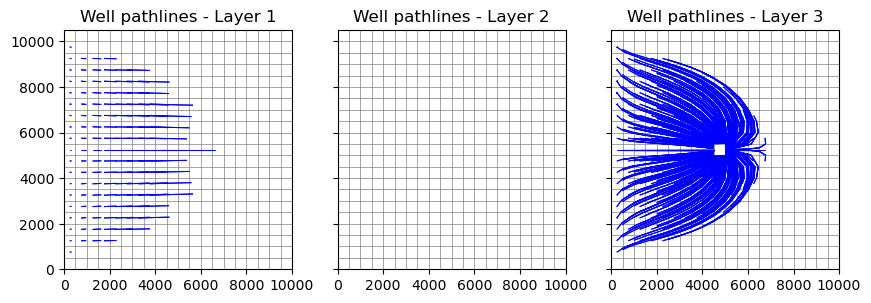

In [7]:
fpth = os.path.join(ws, f"{mpnamf}.mppth") ; ppp  = flopy.utils.PathlineFile(fpth) ; pw = ppp.get_destination_pathline_data(dest_cells=nodew) 
f, axes=plt.subplots(ncols=3,nrows=1,sharey=True,sharex=True,figsize=(10, 5)); axes = axes.flatten(); idax = 0
for k in range(nlay):
    ax = axes[idax] ; ax.set_aspect("equal") ; ax.set_title(f"Well pathlines - Layer {k + 1}")
    mm = flopy.plot.PlotMapView(model=gwf, ax=ax) ; mm.plot_grid(lw=0.5) ; mm.plot_pathline(pw, layer=k, colors='blue', lw=0.75) ; idax += 1

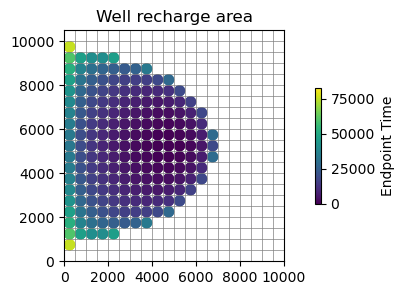

In [8]:
fpth = os.path.join(ws, f"{mpnamf}.mpend")    ; ee = flopy.utils.EndpointFile(fpth)    ; well_epd = ee.get_destination_endpoint_data(dest_cells=nodew) 
fig = plt.figure(figsize=(8, 3))              ; ax = fig.add_subplot(1, 1, 1, aspect="equal")                     ; ax.set_title("Well recharge area")
mm = flopy.plot.PlotMapView(model=gwf, ax=ax) ; mm.plot_grid(lw=0.5)     ; mm.plot_endpoint(well_epd, direction="starting", colorbar=True, shrink=0.5)